In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass
from tqdm import tqdm

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
@dataclass
class ProcessConfig:
    """configure the data generating process"""
    period: int = 40
    seq_len: int = 10000
    num_seeds: int = 3 

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        # generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        tind = np.array((np.arange(0, self.seq_len) % T) < (T // 2))
        tind = tind.astype(int)
        ind = np.where(tind == 1)[0]

        Ydat = Xdat > 0
        Ydat[ind] = Xdat[ind] < 0
        Ydat = Ydat.astype(int)

        Xdat = Xdat.reshape(-1, 1)

        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat < 0
        else:
            Ydat = Xdat > 0

        Xdat = Xdat.reshape(-1, 1)
        tdat = t * np.ones(num_samples)

        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        return x, y, t
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, idx, run_id, test, past=None):
        self.x = torch.from_numpy(data['x']).float()
        self.y = torch.from_numpy(data['y']).long()
        self.t = torch.from_numpy(data['t']).float()

        if test:
            # Use data from time 'idx' onwards for testing
            self.x = self.x[run_id, idx:]
            self.y = self.y[run_id, idx:]
            self.t = self.t[run_id, idx:]
        else:
            if past is None:
                #  # Use data up to time 'idx' onwards for training (full history)
                self.x = self.x[run_id, :idx]
                self.y = self.y[run_id, :idx]
                self.t = self.t[run_id, :idx]
            else:
                # Use the most recent past data up to time 'idx' onwards for training (partial history)
                self.x = self.x[run_id, idx-past:idx]
                self.y = self.y[run_id, idx-past:idx]
                self.t = self.t[run_id, idx-past:idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t
    

class Continuum:
    def __init__(self, data, t_end, run_id):
        """Initialize with the sequences drawn from the process."""
        self.x = torch.from_numpy(data['x'][run_id]).float()
        self.y = torch.from_numpy(data['y'][run_id]).long()
        self.t = torch.from_numpy(data['t'][run_id]).float()
        self.present = 0
        self.t_end = t_end

    def __iter__(self):
        """Return the iterator object itself."""
        return self
    
    def __next__(self):
        """Return the next sample in the sequence or raise StopIteration."""
        if self.present >= self.t_end:
            raise StopIteration
        
        # get current sample
        x = self.x[self.present].unsqueeze(0)
        y = self.y[self.present]
        t = self.t[self.present]

        self.present += 1
        return x, y, t
    
    def get_test_loader_at_present(self):
        test_x = self.x[self.present:]
        test_y = self.y[self.present:]
        test_t = self.t[self.present:]
        test_data = TensorDataset(test_x, test_y, test_t)
        test_loader = DataLoader(
            test_data, 
            batch_size=100,
            shuffle=False
        )
        return test_loader

In [18]:
import torch.nn as nn

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.time_embed = TimeEmbedding(tdim=tdim)
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            t = self.time_embed(t.unsqueeze(-1))
            x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [19]:
def evaluate(model, loader):
    perrs = []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]
            x, y, t = batch
            logits = model(x, t)
            probs = torch.softmax(logits, dim=1)
            err = (probs.argmax(dim=1) != y).float()
            perrs.append(err.cpu().numpy())
    perrs = np.concatenate(perrs)
    ploss = perrs.mean()
    return ploss

In [20]:
period = 20
t_end = 5000
cfg = ProcessConfig(
    period=period,
    seq_len=10000,
    num_seeds=3,
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
prospective_losses = []

for rep in range(cfg.num_seeds):
    print(f"Rep {rep} ...")
    seed = 0
    acorn = seed * 1000 + 1996

    continuum = Continuum(dp.data, t_end=t_end, run_id=seed)
    progress_bar = tqdm(continuum, desc="Training", unit="t")

    model = MLP(prospective=True)
    model.to(device)

    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=0.01,
        # momentum=0.9, 
        # nesterov=True,
        # weight_decay=0.00001
    )
    criterion = nn.CrossEntropyLoss()

    ploss_list = []
    for t_current, (x, y, t) in enumerate(progress_bar):
        model.eval()
        ploss = evaluate(model, continuum.get_test_loader_at_present())
        ploss_list.append(ploss)

        model.train()
        logits = model(x, t)
        loss = criterion(logits.squeeze(), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_description(f"Current Time [{t_current + 1}/{t_end}] - Loss: {loss.item():.3f} - Prosp. Loss: {ploss:.3f}")

    prospective_losses.append(ploss_list)

prospective_risk = np.stack(prospective_losses).mean(axis=0)

Rep 0 ...


Current Time [5000/5000] - Loss: 0.045 - Prosp. Loss: 0.000: : 5000t [02:48, 29.74t/s]


Rep 1 ...


Current Time [5000/5000] - Loss: 0.054 - Prosp. Loss: 0.000: : 5000t [02:50, 29.33t/s]


Rep 2 ...


Current Time [5000/5000] - Loss: 0.024 - Prosp. Loss: 0.000: : 5000t [02:51, 29.17t/s]


In [29]:
import pickle

with open("results_lambda_0_p_0.0.pkl", "rb") as file:
    results = pickle.load(file)

batch_prisk = results['prisk']['Prospective']
batch_t_list = np.arange(20, 500, 1)

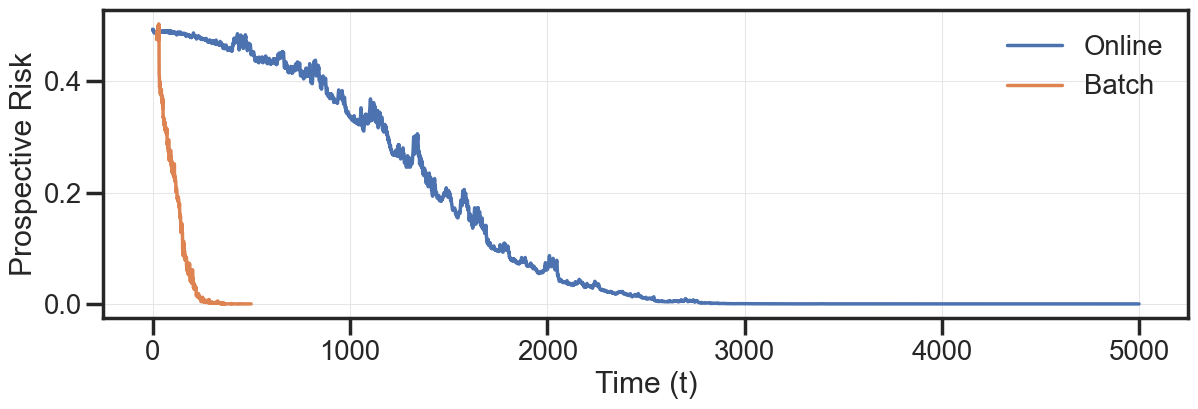

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(context='poster',
            style='ticks',
            font_scale=0.9,
            rc={'axes.grid':True,
                'grid.color':'.9',
                'grid.linewidth':0.75})

fig, ax = plt.subplots(figsize=(14, 4))

online_t_list = np.arange(t_end)

ax.plot(online_t_list, prospective_risk, label="Online", lw=2.5)
ax.plot(batch_t_list, batch_prisk, label="Batch", lw=2.5)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Prospective Risk")
ax.legend()

plt.show()